In [1]:
# Common Imports:
import pandas as pd
import numpy as np
import os

# To allow markdowns in Python Cells:
from IPython.display import display, Markdown
# display(Markdown("# Hello World!"))

# To Plot Pretty Figures:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline 

# allowing for any single variable to print out without using the print statement:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Path to access images
from pathlib import Path

# in-built keras image pre-processing library
from keras.preprocessing import image

In [3]:
# Path to folders with training data
parasitized_path = Path('cell_images/') / 'Parasitized'
not_parasitized_path = Path('cell_images/') / 'Uninfected'

# making sure the directories exist
parasitized_path.is_dir()
not_parasitized_path.is_dir()

True

True

In [4]:
# initializing the lists of images (X) and labels (Y)
images = []
labels = []

In [5]:
# import library to resize images:
from skimage import transform

# setting the new shape of image:
new_shape = (224, 224, 3)

In [6]:
import warnings;
warnings.filterwarnings('ignore');

# Load all the non-malaria images and setting their Y label as 0
for img in not_parasitized_path.glob("*.png"):
    
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)
    
    # resize the image (must be done after it has turned into a np array):
    image_array = transform.resize(image_array, new_shape, anti_aliasing=True)
    
    # scaling the image data to fall between 0-1 since images have 255 brightness values:
    image_array /= 255

    # Add the image to the list of images
    images.append(image_array)

    # For each 'not parasitized' image, the expected value should be 0
    labels.append(0)

In [7]:
# Load all the malaria images and setting their Y label as 1
for img in parasitized_path.glob("*.png"):
    
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)
    
    # resize the image (must be done after it has turned into a np array):
    image_array = transform.resize(image_array, new_shape, anti_aliasing=True)
    
    # scaling the image data to fall between 0-1 since images have 255 brightness values:
    image_array /= 255

    # Add the image to the list of images
    images.append(image_array)

    # For each 'parasitized' image, the expected value should be 1
    labels.append(1)

In [8]:
from sklearn.utils import shuffle
images, labels = shuffle(images, labels)

In [9]:
# Create a single numpy array with all the images we loaded (list to np array)
x_data = np.array(images)

# Also convert the labels to a numpy array from a list
y_data = np.array(labels)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 0)

In [11]:
# type convert the test and training data:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [12]:
f'X_train shape: {X_train.shape}'
f'X_test.shape: {X_test.shape}'

'X_train shape: (480, 224, 224, 3)'

'X_test.shape: (120, 224, 224, 3)'

In [13]:
# one hot encoding Y:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
y_train.shape, y_test.shape

((480, 2), (120, 2))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD

In [16]:
vgg = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape = (224,224,3))

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
    print(layer.name)
    layer.trainable = False #All others as non-trainable.

x = vgg.output
x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

model = Model(vgg.input, x)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2d_22
batc

In [17]:
# model.summary()

In [18]:
from keras.callbacks import ModelCheckpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
hist = model.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          callbacks= callbacks_list,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/20
8/8 [==============================] - 29s 2s/step - loss: 0.2932 - accuracy: 0.8875 - val_loss: 0.2289 - val_accuracy: 0.9333

Epoch 00001: val_accuracy improved from -inf to 0.93333, saving model to model.h5
Epoch 2/20
8/8 [==============================] - 5s 614ms/step - loss: 0.0681 - accuracy: 0.9771 - val_loss: 0.3137 - val_accuracy: 0.9333

Epoch 00002: val_accuracy did not improve from 0.93333
Epoch 3/20
8/8 [==============================] - 5s 613ms/step - loss: 0.0293 - accuracy: 0.9875 - val_loss: 0.5000 - val_accuracy: 0.9167

Epoch 00003: val_accuracy did not improve from 0.93333
Epoch 4/20
8/8 [==============================] - 5s 639ms/step - loss: 0.0124 - accuracy: 0.9937 - val_loss: 0.3898 - val_accuracy: 0.9417

Epoch 00004: val_accuracy improved from 0.93333 to 0.94167, saving model to model.h5
Epoch 5/20
8/8 [==============================] - 5s 620ms/step - loss: 0.0110 - accuracy: 0.9958 - val_loss: 0.3378 - val_accuracy: 0.9333

Epoch 00005: val_acc

In [20]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17662246525287628
Test accuracy: 0.9583333134651184


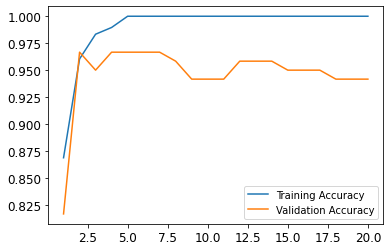

In [21]:
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

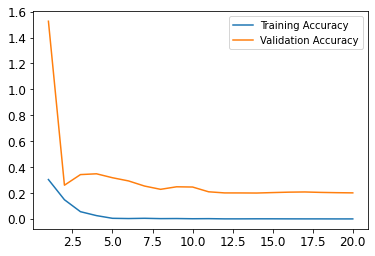

In [22]:
epoch_list = list(range(1, len(hist.history['loss']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['loss'], epoch_list, hist.history['val_loss'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

<AxesSubplot:>

Text(0, 0.5, 'loss, accuracy')

Text(0.5, 0, 'epoch')

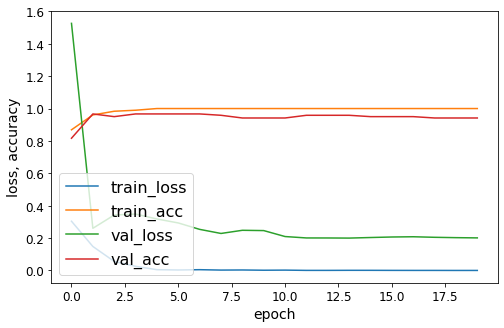

In [26]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.ylabel('loss, accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss','train_acc', 'val_loss','val_acc'],fontsize=16)
plt.show()

<AxesSubplot:>

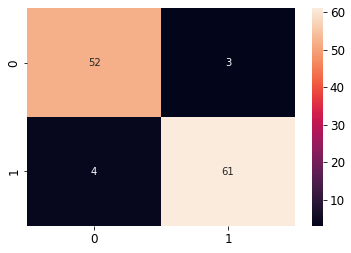

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True,fmt="d")

<AxesSubplot:>

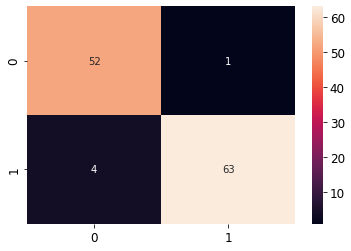

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True,fmt="d")

In [44]:
import scipy

parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)  

224 224
1
(1536, 2)
[ 0.05706302 -0.00891038  0.02382989 ...  0.03717541 -0.04301236
  0.03347349]
(1536,)
(5, 5, 1536)
44.8 44.8
(224, 224, 1536)
0


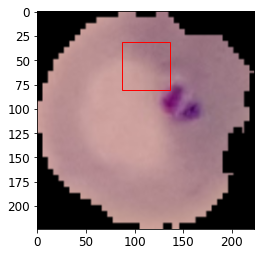

In [79]:
import scipy

parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

print(img.shape[0],img.shape[1])

from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    print(pred_class)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    print(last_layer_weights.shape)
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    print(last_layer_weights_for_pred)
    print(last_layer_weights_for_pred.shape)
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("conv_7b_bn").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    print(last_conv_output.shape)
    
    #Upsample/resize the last conv. output to same size as original image
    h = float((img.shape[0]/last_conv_output.shape[0]))
    w = float((img.shape[1]/last_conv_output.shape[1]))
    print(h,w)
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    print(upsampled_last_conv_output.shape)
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 1536)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    

import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])

In [34]:
vgg = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape = (224,224,3))

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
#     layer.trainable = False #All others as non-trainable.

x = vgg.output
x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

model = Model(vgg.input, x)
# model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
for layer in model.layers:    #Set block5 trainable, all others as non-trainable
    print(layer.name)

input_3
conv2d_203
batch_normalization_203
activation_391
conv2d_204
batch_normalization_204
activation_392
conv2d_205
batch_normalization_205
activation_393
max_pooling2d_4
conv2d_206
batch_normalization_206
activation_394
conv2d_207
batch_normalization_207
activation_395
max_pooling2d_5
conv2d_211
batch_normalization_211
activation_399
conv2d_209
conv2d_212
batch_normalization_209
batch_normalization_212
activation_397
activation_400
average_pooling2d_1
conv2d_208
conv2d_210
conv2d_213
conv2d_214
batch_normalization_208
batch_normalization_210
batch_normalization_213
batch_normalization_214
activation_396
activation_398
activation_401
activation_402
mixed_5b
conv2d_218
batch_normalization_218
activation_406
conv2d_216
conv2d_219
batch_normalization_216
batch_normalization_219
activation_404
activation_407
conv2d_215
conv2d_217
conv2d_220
batch_normalization_215
batch_normalization_217
batch_normalization_220
activation_403
activation_405
activation_408
block35_1_mixed
block35_1_conv


In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_388 (Conv2D)             (None, 5, 5, 224)    129024      activation_575[0][0]             
__________________________________________________________________________________________________
batch_normalization_388 (BatchN (None, 5, 5, 224)    672         conv2d_388[0][0]                 
__________________________________________________________________________________________________
activation_576 (Activation)     (None, 5, 5, 224)    0           batch_normalization_388[0][0]    
__________________________________________________________________________________________________
conv2d_386 (Conv2D)             (None, 5, 5, 192)    399360      block8_5_ac[0][0]                
__________________________________________________________________________________________________
conv2d_389 (Conv2D)             (None, 5, 5, 256)    172032      activation_576[0][0]             
__________

In [39]:
img = predicted_as_para[im]
img.shape

(224, 224, 3)

In [59]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
im

56

In [66]:
predicted_as_para.shape[0]-1

63

In [68]:
predicted_as_para[im].shape

(224, 224, 3)

2
1
(1536, 2)
[ 0.02955178  0.03697651 -0.00362216 ...  0.0017333   0.04565819
 -0.01457618]
(1536,)
(5, 5, 1536)
44.8 44.8
(224, 224, 1536)
0


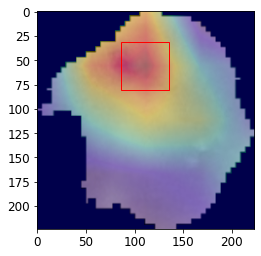

In [47]:
import scipy

parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    

# print(img.shape[0],img.shape[1])

from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    print(pred_class)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    print(last_layer_weights.shape)
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    print(last_layer_weights_for_pred)
    print(last_layer_weights_for_pred.shape)
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("conv_7b_bn").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    print(last_conv_output.shape)
    
    #Upsample/resize the last conv. output to same size as original image
    h = float((img.shape[0]/last_conv_output.shape[0]))
    w = float((img.shape[1]/last_conv_output.shape[1]))
    print(h,w)
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    print(upsampled_last_conv_output.shape)
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 1536)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

    

import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
print(im)
# im = 49
heat_map =plot_heatmap(predicted_as_para[im])

# img = predicted_as_para[im]
# plt.imshow(predicted_as_para[im])